<a href="https://colab.research.google.com/github/duongdqq/TF_guide/blob/master/TF_basics/1_Eager_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Introduction 

* TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later.
* This makes it easy to get started with TensorFlow and debug models, and it reduces boilerplate as well. 

* Eager execution is a flexible machine learning platform for research and experimentation, providing:

  * An intuitive interface—Structure your code naturally and use Python data structures. Quickly iterate on small models and small data.
  * Easier debugging—Call ops directly to inspect running models and test changes. Use standard Python debugging tools for immediate error reporting.
  * Natural control flow—Use Python control flow instead of graph control flow, simplifying the specification of dynamic models.
* Eager execution supports most TensorFlow operations and GPU acceleration.

## 2 Set up and basic usage

In [1]:
import os
import tensorflow as tf
import cProfile

In [2]:
tf.executing_eagerly()

True

In [3]:
x = [[2.]]
m = tf.matmul(x, x)
print('hello, {}'.format(m))

hello, [[4.]]


* Enabling eager execution changes how TensorFlow operations behave—now they immediately evaluate and return their values to Python.

* tf.Tensor objects reference concrete values instead of symbolic handles to nodes in a computational graph. 
* Since there isn't a computational graph to build and run later in a session, it's easy to inspect results using print() or a debugger. 
* Evaluating, printing, and checking tensor values does not break the flow for computing gradients.

* Eager execution works nicely with NumPy. 
* NumPy operations accept tf.Tensor arguments. 
* The TensorFlow tf.math operations convert Python objects and NumPy arrays to tf.Tensor objects. 
* The tf.Tensor.numpy method returns the object's value as a NumPy ndarray.

In [4]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)  

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [5]:
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [6]:
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [7]:
import numpy as np 
c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [8]:
# Obtain numpy value from a tensor:
print(a.numpy())

[[1 2]
 [3 4]]


# 3 Dynamic control flow

* A major benefit of eager execution is that all the functionality of the host language is available while your model is executing.

In [9]:
def fizzbuzz(max_num):
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy() + 1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())

In [10]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


# 4 Eager training

## 4.1 Computing gradients

* Automatic differentiation is useful for implementing machine learning algorithms such as backpropagation for training neural networks. 
* During eager execution, use tf.GradientTape to trace operations for computing gradients later.

In [11]:
w = tf.Variable([[5.0]])
with tf.GradientTape() as tape:
  loss = w ** 3

grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[74.99999]], shape=(1, 1), dtype=float32)


## 4.2 Train a model

* The following example creates a multi-layer model that classifies the standard MNIST handwritten digits. It demonstrates the optimizer and layer APIs to build trainable graphs in an eager execution environment.

In [12]:
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[..., tf.newaxis]/255, tf.float32),
    tf.cast(mnist_labels, tf.int64))
)
dataset = dataset.shuffle(1000).batch(32)

11493376/11490434 [==============================] - 0s 0us/step


In [13]:
mnist_model = tf.keras.Sequential([
                                   tf.keras.layers.Conv2D(16, [3,3], activation='relu',
                                                          input_shape=(None, None, 1)),
                                   tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
                                   tf.keras.layers.GlobalAveragePooling2D(),
                                   tf.keras.layers.Dense(10)
])

Even without training, call the model and inspect the output in eager execution:

In [14]:
for images, labels in dataset.take(1):
  print('Logits: ', mnist_model(images[0:1]).numpy())

Logits:  [[ 0.02196483 -0.02409778 -0.03759912  0.00768842 -0.00934942 -0.00971232
  -0.00691688 -0.03016222 -0.00720448 -0.00372962]]


* While keras models have a builtin training loop (using the fit method), sometimes you need more customization. Here's an example, of a training loop implemented with eager:

In [15]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

* Note: Use the assert functions in tf.debugging to check if a condition holds up. This works in eager and graph execution.

In [16]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)

    # add asserts to check the shape of the output
    tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [17]:
def train(epochs):
  for epoch in range(epochs):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print('Epoch {} finished'.format(epoch))

In [18]:
train(3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

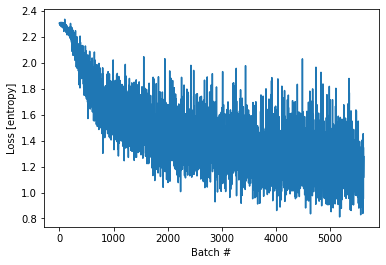

In [19]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("Batch #")
plt.ylabel("Loss [entropy]")

## Variables and optimizers

* tf.Variable objects store mutable tf.Tensor like values accessed druring training to make automatic differentiation easier
* The collections of variables can be encapsulated into layers or models, along with methods that operate on them
*  The main difference between layers and models is that models add methods like Model.fit, Model.evaluate, and Model.save.
* For example, the automatic differentiation example above can be rewritten:

In [20]:
class Linear(tf.keras.Model):
  def __init__(self):
    super(Linear, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  
  def call(self, inputs):
    return inputs * self.W + self.B

In [21]:
NUM_EXAMPLES = 200
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

In [22]:
training_inputs

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([ 1.5522264 ,  1.0661751 ,  1.6272875 ,  0.91464126,  1.6582117 ,
        1.2402873 ,  0.47318274,  0.6320585 , -1.0162326 , -0.2162437 ,
       -2.9449537 , -1.3076224 , -1.1550132 , -0.29062745,  0.6295541 ,
        0.10972717, -0.69485855,  1.6181071 ,  0.36053053, -1.0107787 ,
        1.3451629 ,  0.14021084,  1.1599495 ,  0.8769111 , -0.33519492,
       -1.764859  , -0.70656884, -1.6338934 , -0.98925364,  1.0160099 ,
       -0.5194685 , -0.90983677, -0.5818362 , -0.9289189 , -1.1617826 ,
        0.45726502, -0.4275062 , -0.03037437,  0.46455598, -0.14927578,
       -0.15651882,  0.52824587,  0.30282846, -0.65383667, -0.26245287,
       -1.0209305 ,  0.23553392, -0.00739842,  0.26187968,  0.39135993,
        0.61691207,  1.5104048 , -0.23600745, -1.8487359 ,  0.5356158 ,
        0.467539  ,  0.88926786, -1.6749061 ,  1.3740337 , -0.34538084,
        0.01321516, -0.31902903, -0.5139741 ,  0.1235019 , -1.2011687 ,
        1.513405

In [23]:
noise

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([ 0.04284611,  0.9855079 ,  0.20295866, -0.18875854, -0.0672558 ,
       -1.8348213 , -1.6443061 ,  0.23730664,  0.8971382 , -0.15668663,
       -1.1211118 ,  0.90901047,  1.8969855 , -0.12165495,  1.9860392 ,
       -1.1760411 ,  1.318423  ,  1.5616226 ,  0.09512167,  1.3524095 ,
        0.00857109,  0.6113704 ,  0.06899816, -0.07478228,  0.21881661,
       -0.44207168, -0.6350746 ,  0.5395458 ,  0.72144586,  0.9470714 ,
        0.48019513,  0.42135933, -0.0904134 , -0.88955116,  0.9018326 ,
       -1.4249989 ,  0.2860452 , -0.6432894 ,  1.3408415 ,  0.15908968,
        0.7857934 ,  0.88868624,  0.30231386, -0.8342007 , -0.50222814,
        1.0735728 ,  1.4301332 , -0.43298766, -0.66920835, -0.9096856 ,
       -0.86308384,  1.3585142 , -0.72813034, -1.6966865 , -1.0817746 ,
       -0.25623304,  0.39441574,  1.0117314 ,  0.9399577 ,  0.42848295,
        2.1657481 , -0.15663873,  0.23556428, -0.55705637, -0.69490737,
       -1.781291

In [24]:
training_outputs

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([ 6.6995254e+00,  6.1840334e+00,  7.0848212e+00,  4.5551653e+00,
        6.9073792e+00,  3.8860407e+00,  1.7752422e+00,  4.1334820e+00,
       -1.5155977e-01,  1.1945822e+00, -7.9559727e+00, -1.0138569e+00,
        4.3194580e-01,  1.0064627e+00,  5.8747015e+00,  1.1531403e+00,
        1.2338474e+00,  8.4159441e+00,  3.1767132e+00,  3.2007349e-01,
        6.0440598e+00,  3.0320029e+00,  5.5488472e+00,  4.5559511e+00,
        1.2132319e+00, -3.7366483e+00, -7.5478125e-01, -2.3621342e+00,
       -2.4631518e-01,  5.9951015e+00,  9.2178977e-01, -3.0815098e-01,
        1.6407794e-01, -1.6763079e+00, -5.8351517e-01,  1.9467963e+00,
        1.0035266e+00,  1.2655876e+00,  4.7345095e+00,  1.7112623e+00,
        2.3162370e+00,  4.4734240e+00,  3.2107992e+00, -7.9571062e-01,
        7.1041322e-01,  1.0781169e-02,  4.1367350e+00,  1.5448171e+00,
        2.1164308e+00,  2.2643943e+00,  2.9876523e+00,  7.8897290e+00,
        5.6384730e-01, -5.242

In [25]:
# the loss function to be optimized
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))


def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])  # tính đạo hàm theo model.W và model.B

* Next:
- Create the model.
- The Derivatives of a loss function with respect to model parameters.
- A strategy for updating the variables based on the derivatives.

In [26]:
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_outputs, training_outputs)))

steps = 300
for i in range(steps):
  grads = grad(model, training_inputs, training_inputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print('Loss at step {:3d}: {:.3f}'.format(i, loss(model, training_inputs, training_outputs)))

Initial loss: 481.795
Loss at step   0: 61.679
Loss at step  20: 21.011
Loss at step  40: 6.261
Loss at step  60: 2.144
Loss at step  80: 2.058
Loss at step 100: 3.248
Loss at step 120: 4.632
Loss at step 140: 5.840
Loss at step 160: 6.784
Loss at step 180: 7.484
Loss at step 200: 7.987
Loss at step 220: 8.342
Loss at step 240: 8.590
Loss at step 260: 8.761
Loss at step 280: 8.879


In [27]:
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Final loss: 8.956


In [28]:
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

W = 1.0174391269683838, B = 0.027711033821105957


Note: Variables persist until the last reference to the python object is removed, and is the variable is deleted.


## Object-based saving

A tf.keras.Model includes a convenient save_weights method allowing you to easily create a checkpoint:

In [29]:
model.save_weights('weights')
status = model.load_weights('weights')

Using tf.train.Checkpoint you can take full control over this process.

In [30]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [31]:
x.assign(2.)  # assign a new value to the variables and save
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


In [32]:
x.assign(11.)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


- To save and load models, tf.train.Checkpoint stores the internal state of objects, without requiring hidden variables. 
- To record the state of a model, an optimizer, and a global step, pass them to a tf.train.Checkpoint:

In [33]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(10)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

checkpoint_dir = 'path/to/model_dir'

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

- Note: In many training loops, variables are created after tf.train.Checkpoint.restore is called. 
- These variables will be restored as soon as they are created, and assertions are available to ensure that a checkpoint has been fully loaded

## Object-oriented metrics

- tf.keras.metrics are stored as objects. 
- Update a metric by passing the new data to the callable, and retrieve the result using the tf.keras.metrics.result method

In [34]:
m = tf.keras.metrics.Mean('loss')
m(6)
print(m.result())
m(7)
print(m.result())
m([8,9])
print(m.result())

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(6.5, shape=(), dtype=float32)
tf.Tensor(7.5, shape=(), dtype=float32)


## Summaries and TensorBoard

- TensorBoard is a visualization tool for understanding, debugging and optimizing the model training process. 
- It uses summary events that are written while executing the program.
- You can use tf.summary to record summaries of variable in eager execution. 
- For example, to record summaries of loss once every 100 training steps:

In [35]:
logdir = './tb/'
writer = tf.summary.create_file_writer(logdir)

steps = 100
with writer.as_default():
  for i in range(steps):
    step = i + 1
    loss = 1 - 0.01 * step
    if step % 100 == 0:
      tf.summary.scalar('loss', loss, step=step)

## Advanced automatic differentiation topics

### Dynamic models

* tf.GradientTape can also be used in dynamic models. This example for a backtracking line search algorithm looks like normal NumPy code, except there are gradients and is differentiable, despite the complex control flow:

In [36]:
def line_search_step(fn, init_x, rate=1.0):
  with tf.GradientTape() as tape:
    # variables are automatically tracked
    # but to calculate a gradient from a tensor, you must watch it
    tape.watch(init_x)
    value = fn(init_x)
  grad = tape.gradient(value, init_x)
  grad_norm = tf.reduce_sum(grad * grad)
  init_value = value
  while value > init_value - rate * grad_norm:
    x = init_x - rate * grad
    value = fn(x)
    rate /= 2.0
  return x, value

### Custom gradients

* Custom gradients are an easy way to override gradients
* Within the forward function, define the gradient with respect to the inputs, outputs, or intermediate results.
* For example, here's an easy way to clip the norm of the gradients in the backward pass:

In [37]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
  y = tf.identity(x)
  def grad_fn(default):
    return [tf.clip_by_norm(default, norm), None]
  return y, grad_fn

* Custom gradients are commonly used to provide a numerically stable gradient for a sequence of operations:

In [38]:
def log1pexp(x):
  return tf.math.log(1 + tf.exp(x))


def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)

In [39]:
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [40]:
# However, x = 100 fails because of numerical instability.
grad_log1pexp(tf.constant(100.)).numpy()

nan

* Here, the log1pexp function can be analytically simplified with a custom gradient. 
* The implementation below reuses the value for tf.exp(x) that is computed during the forward pass—making it more efficient by eliminating redundant calculations:


In [41]:
@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)

In [42]:
# As before, the gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [43]:
# And the gradient computation also works at x = 100.
grad_log1pexp(tf.constant(100.)).numpy()

1.0

## Performance

* Computation is automatically offloaded to GPUs during eager execution. 
* If you want control over where a computation runs you can enclose it in a tf.device('/gpu:0') block (or the CPU equivalent):

In [50]:
import time

def measure(x, steps):
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x,x)
  # tf.matmul can return before completing the matrix multiplication
  # (e.g., can return after enqueing the operation on a CUDA stream).
  # The x.numpy() call below will ensure that all enqueued operations
  # have completed (and will also copy the result to host memory,
  # so we're including a little more than just the matmul operation
  # time).
  _ = x.numpy()
  end = time.time()
  return end - start


shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# run on CPU
with tf.device('/cpu:0'):
  print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# run on gpu if available
if tf.config.experimental.list_physical_devices('GPU'):
  with tf.device('/gpu:0'):
    print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
  print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 5.544374227523804 secs
GPU: 0.163132905960083 secs


A tf.Tensor object can be copied to a different device to execute its operations:



In [53]:
  if tf.config.experimental.list_physical_devices('GPU'):
    x = tf.random.normal([10, 10])

    x_gpu = x.gpu()
    x_cpu = x.cpu()

    _ = tf.matmul(x_cpu, x_cpu)
    _ = tf.matmul(x_gpu, x_gpu)


Instructions for updating:
Use tf.identity instead.
Instructions for updating:
Use tf.identity instead.


### Benchmarks

* For compute-heavy models, such as ResNet50 training on a GPU, eager execution performance is comparable to tf.function execution. 
* But this gap grows larger for models with less computation and there is work to be done for optimizing hot code paths for models with lots of small operations.

## Work with functions

* While eager execution makes development and debugging more interactive, TensorFlow 1.x style graph execution has advantages for distributed training, performance optimizations, and production deployment. 
* To bridge this gap, TensorFlow 2.0 introduces functions via the tf.function API. For more information, see the tf.function guide.